In [1]:
# heartparser.py
#   Author: Kristy Yancey Spencer
#
#   This script parses the Apple Health export xml file for Heart Rate and
#   Blood Pressure data and produces graphs of the data for given date ranges.

import numpy as np
from datetime import date, datetime, timedelta as td
from matplotlib import pyplot, dates as mdates
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
from openpyxl import load_workbook
from pandas import DataFrame, ExcelWriter, Index, Timestamp, DatetimeIndex
from xml.dom import minidom
from matplotlib import pyplot as plt





    
def weeklyhr(datelist, df_hr):
    # This module filters through df_hr and returns a dataframe containing
    # weekly heart rate values.
    list_weekhr = []
    dict_weekday = {}
    for di in range(len(datelist)):
        year = int(datelist[di][:4])
        month = int(datelist[di][5:7])
        day = int(datelist[di][8:10])
        weekj = date(year, month, day).isocalendar()[1]
        if weekj not in dict_weekday:
            dict_weekday[weekj] = mdates.date2num(datetime(year, month, day))
        try:
            i = df_hr.index.get_loc(datelist[di])
            di_hr = df_hr.get_value(i, 1, takeable=True)
            list_weekhr.append({
                'Date': mdates.date2num(datetime(year, month, day)),
                'PlotDate': dict_weekday[weekj], 
                'Week': weekj,
                'Heart Rate (bpm)': float(di_hr)
            })
        except:
            pass
    df_weekhr = DataFrame(list_weekhr)
    print(df_weekhr)
    return df_weekhr


def makehrplot(dates, df_week):
    # This module plots the heart rate data between the dates given.
    plotname = 'heartrate_{0}to{1}'.format(dates[0], dates[1])
    fig, ax = pyplot.subplots()
    fig.dpi = 2000
    regplot(x='PlotDate', y='Heart Rate (bpm)', data=df_week,
            x_estimator=np.mean, color='#D42426', ax=ax)
    # assign formatter for the xaxis ticks.
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
    pyplot.savefig(plotname + '.pdf', format='pdf')
    # pyplot.savefig(plotname + '.jpg', format='jpg')
    pyplot.close()


def plotbp(dates, datelist, recordlist):
    # This module parses the blood pressure data from the xml file and
    # calls the plotting function.
    cat1 = "HKQuantityTypeIdentifierBloodPressureSystolic"
    df_bps = parse(cat1, recordlist)
    df_bps.columns = ['Time', 'BP Systolic']
    cat2 = "HKQuantityTypeIdentifierBloodPressureDiastolic"
    df_bpd = parse(cat2, recordlist)
    df_bpd.columns = ['Time', 'BP Diastolic']
    df_bp = df_bps.merge(df_bpd, left_index=True, right_index=True, 
                         how='outer')
    df_bp.drop_duplicates()
    df_bloodpressure = select_bprange(datelist, df_bp)
    makebpplot(dates, df_bloodpressure)


def select_bprange(datelist, df_bp):
    # This module filters df_bp with the given datelist and returns a usable
    # dataframe.
    list_bp = []
    for di in range(len(datelist)):
        year = int(datelist[di][:4])
        month = int(datelist[di][5:7])
        day = int(datelist[di][8:10])
        try:
            i = df_bp.index.get_loc(datelist[di])
            di_bp_sys = df_bp.get_value(i, 1, takeable=True)
            di_bp_dia = df_bp.get_value(i, 3, takeable=True)
            list_bp.append({
                    'Date': mdates.date2num(datetime(year, month, day)),
                    'Blood Pressure': di_bp_sys[0],
                    'Type': 'Systolic'
                })
            list_bp.append({
                    'Date': mdates.date2num(datetime(year, month, day)),
                    'Blood Pressure': di_bp_dia[0],
                    'Type': 'Diastolic'
                })
        except:
            pass
    df_bloodpressure = DataFrame(list_bp)
    print(df_bloodpressure)
    return df_bloodpressure
    
    
def makebpplot(dates, df_bp):
    # This module plots the blood pressure data between the dates given.
    plotname = 'bloodpressure_{0}to{1}'.format(dates[0], dates[1])
    fig, ax = pyplot.subplots()
    fig.dpi = 2000
    kws = dict(linewidth=1, edgecolor="w")
    bpplot = lmplot(x='Date', y='Blood Pressure', data=df_bp, hue='Type',
                    palette='Set1', aspect=1.5, markers=['^', 'v'],
                    legend_out=False, fit_reg=False, scatter_kws=kws)
    ax.legend(loc='upper right', frameon=True)
    # assign formatter for the xaxis ticks.
    axes = bpplot.axes
    axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
    # put the labels at 45deg since they tend to be too long
    fig.autofmt_xdate()
    pyplot.savefig(plotname + '.pdf', format='pdf')
    # pyplot.savefig(plotname + '.jpg', format='jpg')
    pyplot.close()
    
    
def makedatelist(dates):
    # This module creates a list of days from dates[0] to dates[1].
    startyr, startmn, startdy = int(dates[0][0:4]), int(dates[0][5:7]), int(dates[0][8:10])
    endyr, endmn, enddy = int(dates[1][0:4]), int(dates[1][5:7]), int(dates[1][8:10])
    # Make date list
    d1 = date(startyr, startmn, startdy)
    d2 = date(endyr, endmn, enddy)
    delta = d2 - d1
    datelist = []
    for i in range(delta.days + 1):
        di = d1 + td(days=i)
        datelist.append(di.strftime("%Y-%m-%d"))
    return datelist


def parse(category, recordlist):
    # This module parses the xml file for category's data and
    # returns a Pandas Dataframe
    dates = []
    datalist = []
    for s in recordlist:
        if s.attributes['type'].value == category:
            date = s.attributes['startDate'].value[:10]
            time = s.attributes['startDate'].value[11:16]
            datum = s.attributes['value'].value
            dates.append(date)
            datalist.append([time, int(datum)])
    dfindex = Index(dates, name='Date')
    df = DataFrame(datalist, index=dfindex)
    return df

def parse_float(category, recordlist):
    # This module parses the xml file for category's data and
    # returns a Pandas Dataframe
    dates = []
    datalist = []
    for s in recordlist:
        if s.attributes['type'].value == category:
            date = s.attributes['startDate'].value[:16] #scollis edit to get time into date
            time = s.attributes['startDate'].value[11:16]
            datum = s.attributes['value'].value
            dates.append(date)
            datalist.append([time, float(datum)])
    dfindex = DatetimeIndex(dates, name='Date')
    df = DataFrame(datalist, index=dfindex)
    return df




In [2]:
print('Starting')
xmldoc = minidom.parse('/Users/scollis/Downloads/apple_health_export 2/export.xml')
print('Parsed and now ordering')
recordlist = xmldoc.getElementsByTagName('Record')
del xmldoc
#plotheartrate(dates, datelist, recordlist)
#plotbp(dates, datelist, recordlist)


Starting
Parsed and now ordering


In [3]:

# This module parses the heart rate data from the xml file and calls
# the plotting function.
category = "HKQuantityTypeIdentifierBodyMass"
df_mass = parse_float(category, recordlist)
df_mass.columns = ['Time', 'Mass (kg)']
#df_mass = df_mass.set_index('Time')
    

In [4]:
df_mass.keys()

Index(['Time', 'Mass (kg)'], dtype='object')

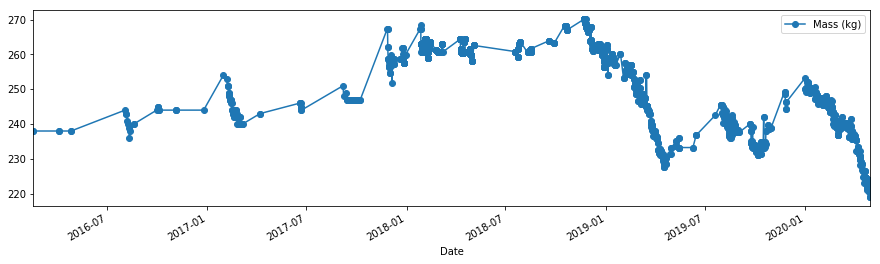

In [5]:
ax = df_mass.plot(marker='o',figsize=(15,4))
#ax.set_xlim(Timestamp('2019-01-02'), Timestamp('2020-03-01'))


In [6]:
dates_array = df_mass.index.values

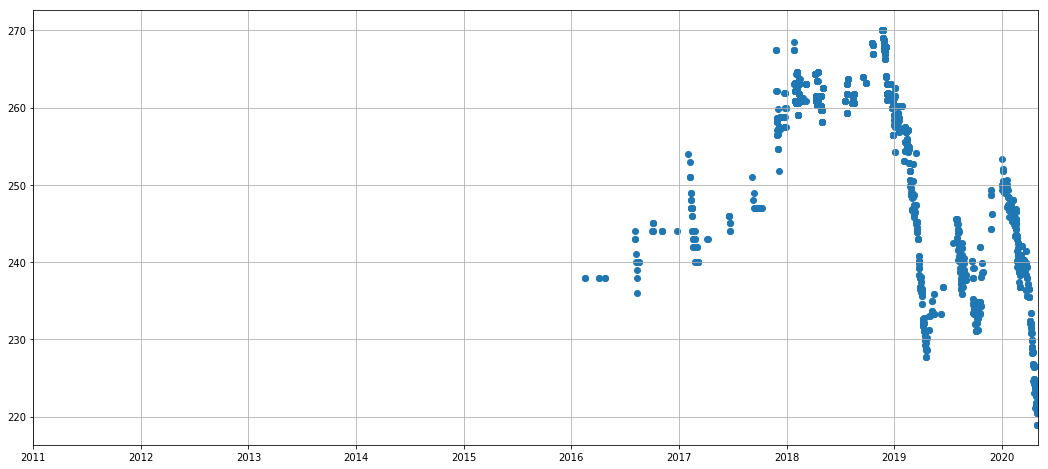

In [7]:
fig= plt.figure( figsize=(18,8) )
ax  = fig.add_subplot(111)
ax.scatter(dates_array, df_mass['Mass (kg)'])
ax.set_xlim(Timestamp('2011-01-02'), Timestamp('2020-05-01'))
plt.grid()

In [26]:
#two epochs
start_of_year = df_mass['2020-1-1':'2020-3-31'].sort_values('Date')
dry_april = df_mass['2020-4-1':'2020-4-30'].sort_values('Date')

In [27]:
dry_april 

,Time,Mass (kg)
Date,,
2020-04-02 00:00:00,00:00,236.556
2020-04-02 06:03:00,06:03,236.556
2020-04-02 07:57:00,07:57,236.556
2020-04-03 00:00:00,00:00,235.454
2020-04-03 06:03:00,06:03,235.454
2020-04-03 06:39:00,06:39,235.454
2020-04-03 06:49:00,06:49,235.454
2020-04-04 00:00:00,00:00,232.367
2020-04-04 06:17:00,06:17,232.367


In [28]:
#fit to start of year
#x = np.arange(start_of_year['Mass (kg)'].size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
days1 = (start_of_year.index.values - start_of_year.index.values[0]).astype('timedelta64[D]')\
       / np.timedelta64(1, 'D')
fit = np.polyfit(days1, start_of_year['Mass (kg)'], 1)
fit_fn = np.poly1d(fit)

#fit to Dry april
days2 = (dry_april.index.values - dry_april.index.values[0]).astype('timedelta64[D]')\
        / np.timedelta64(1, 'D')
fit2 = np.polyfit(days2, dry_april['Mass (kg)'], 1)
fit_fn2 = np.poly1d(fit)


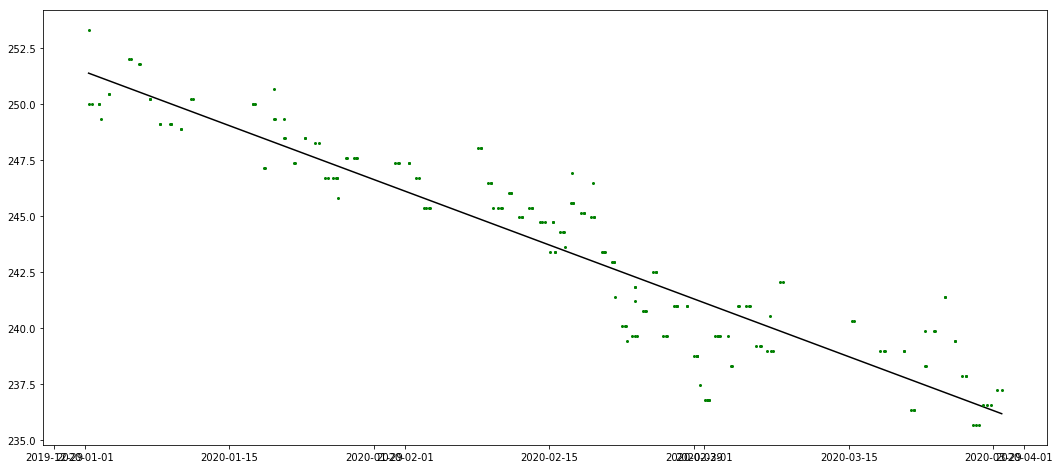

In [29]:
fx = np.array([days1[0], days1[-1]])
start_dates_array = start_of_year.index.values
ft = np.array([start_dates_array[0], start_dates_array[-1]])

fig= plt.figure( figsize=(18,8) )

fff = fit[0]*fx + fit[1]

plt.plot(ft, fff, 'k-')
plt.plot(start_dates_array, start_of_year['Mass (kg)'], 'go', ms=2)

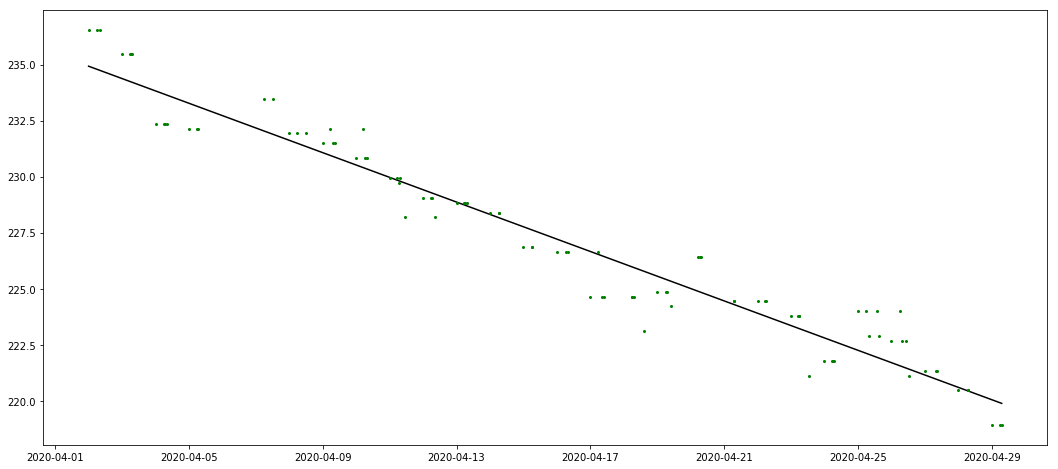

In [30]:
fx2 = np.array([days2[0], days2[-1]])
april_dates_array = dry_april.index.values
ft2 = np.array([april_dates_array[0], april_dates_array[-1]])

fig= plt.figure( figsize=(18,8) )
ax  = fig.add_subplot(111)
fff2 = fit2[0]*fx2 + fit2[1]

plt.plot(ft2, fff2, 'k-')
plt.plot(april_dates_array, dry_april['Mass (kg)'], 'go', ms=2)

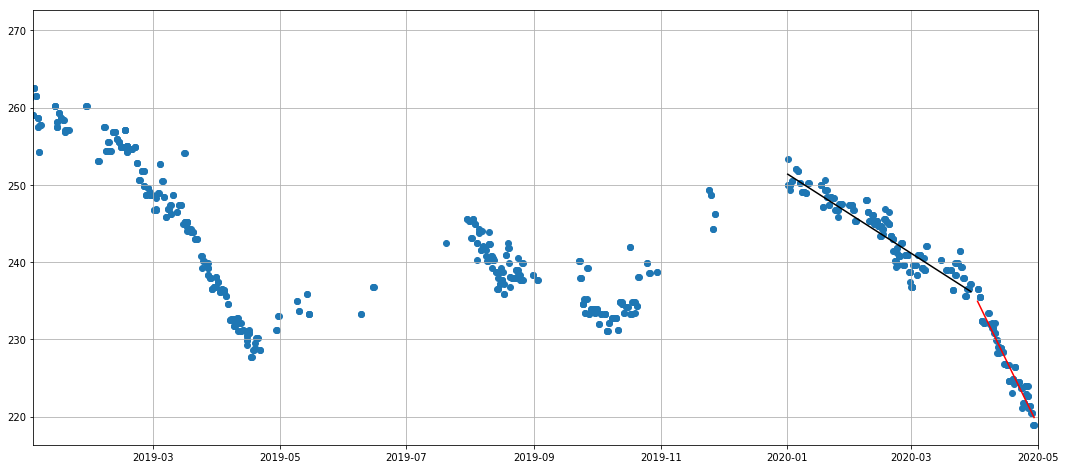

In [31]:
fig= plt.figure( figsize=(18,8) )
ax  = fig.add_subplot(111)
ax.scatter(dates_array, df_mass['Mass (kg)'])
ax.set_xlim(Timestamp('2019-01-02'), Timestamp('2020-05-01'))
plt.plot(ft, fff, 'k-')
plt.plot(ft2, fff2, 'r-')

plt.grid()


#


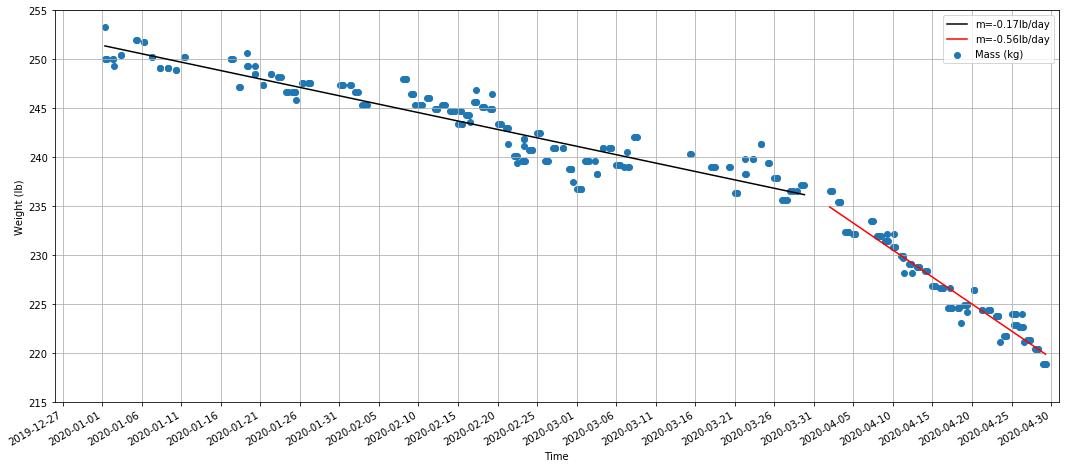

In [33]:


fig= plt.figure( figsize=(18,8) )
ax  = fig.add_subplot(111)
ax.scatter(dates_array, df_mass['Mass (kg)'])
ax.plot(ft, fff, 'k-', label="m={:.2f}lb/day".format(fit[0]))
ax.plot(ft2, fff2, 'r-', label="m={:.2f}lb/day".format(fit2[0]))
ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim(Timestamp('2019-12-26'), Timestamp('2020-05-01'))
ax.set_ylim(215,255)
fig.autofmt_xdate()
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Weight (lb)')
plt.savefig('/Users/scollis/notebooks/HKwloss.png')


#


In [106]:
print(fit)
print(fit2)

[-1.72636150e-01  2.51371626e+02]
[ -0.62969398 234.9387201 ]


In [ ]:
st = 218
xs = wt_df.date[st::] - pd.datetime(2018,11,1)
x = np.array(xs.dt.days)
idx = ~np.isnan(wt_df['awt'][st::])

fit = np.polyfit(x[idx], wt_df['awt'][st::][idx], 1)
fit_fn = np.poly1d(fit)

In [ ]:
sd1 = pd.datetime(2018,11,10)
ed1 = pd.datetime(2019, 3,12)
end_map = pd.datetime(2019, 4,13)

in_range1 = np.logical_and(wt_df.date > sd1, wt_df.date < ed1)
in_mapril = np.logical_and(wt_df.date > ed1, wt_df.date < end_map) #wt_df.date > ed1